# Event Study Analysis of Tim Cook's Tweets on Apple Stock

### Introduction

This notebook conducts an **Event Study** to analyze the impact of specific events, such as Tim Cook's tweets, on Apple's stock price and trading volume. The study is organized into three main sections:

1. **Data Loading and Preprocessing**: We load and preprocess Apple's stock data, S&P 500 index data, and event data, focusing on returns and trading volumes during market open times.

2. **Abnormal Return Analysis**
   - **Extract Windows for Returns**: Define estimation and event windows to capture abnormal returns.
   - **Calculating AR, CAR, AAR, and CAAR**: Measure the deviation of actual returns from expected returns, and aggregate these measures across events.
   - **Statistical Tests and Visualization**: Perform t-tests to assess the significance of AR, CAR, AAR, and CAAR, and visualize the results.

3. **Abnormal Volume Analysis**
   - **Extract Windows for Volume**: Define windows for analyzing abnormal trading volumes.
   - **Calculating AV, CAV, AAV, and CAAV**: Evaluate deviations in trading volumes and aggregate these measures across events.
   - **Statistical Tests and Visualization**: Conduct statistical tests and visualize the impact of events on trading volumes.

This notebook offers a comprehensive analysis of how key events influence Apple’s stock performance, using both return and volume metrics.

## 1. Data Loading and Preprocessing

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_1samp

# File paths
tweets_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/Tweets_Tim_Cook_Event_Study.csv'
stock_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/Apple_minute_historical_data.csv'
market_file_path = '/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Dataset/S&P500_minute_historical_data.csv'

# Load datasets
tweets_market_open = pd.read_csv(tweets_file_path)
price_aapl = pd.read_csv(stock_file_path)
snp500 = pd.read_csv(market_file_path)

In [2]:
# Convert datetime columns to datetime objects
tweets_market_open['datetime'] = pd.to_datetime(tweets_market_open['datetime'], format='%d/%m/%Y %H:%M')
price_aapl['Date'] = pd.to_datetime(price_aapl['Date'], format='%d/%m/%Y %H:%M')
snp500['Date'] = pd.to_datetime(snp500['Date'], format='%d/%m/%Y %H:%M')

# Calculate returns
price_aapl['Return'] = price_aapl['Close'].pct_change()
snp500['Return'] = snp500['Close'].pct_change()

# Set the datetime as the index for price_aapl and snp500
price_aapl.set_index('Date', inplace=True)
snp500.set_index('Date', inplace=True)

# Filter tweets to include only those during market open times
tweets_market_open['market_open'] = tweets_market_open['datetime'].isin(price_aapl.index)
tweets_market_open = tweets_market_open[tweets_market_open['market_open']].copy()

# Ensure 'Volume' column is numeric
price_aapl['Volume'] = pd.to_numeric(price_aapl['Volume'], errors='coerce')

In [3]:
# This research has already filtered tweets during market open times. If you do not filter them before the analysis, you can use this code.
# Determine if the tweet falls within the specific time window relative to the market open
def mark_event(row, price_aapl_index):
    tweet_time = row['datetime']
    time_window_start = tweet_time - pd.Timedelta(minutes=30)
    time_window_end = tweet_time + pd.Timedelta(minutes=10)
    
    # Filter the index for the same day as the tweet
    same_day_index = price_aapl_index[price_aapl_index.date == tweet_time.date()]

    # Check if the entire window falls within the same day index
    if len(same_day_index) > 0 and time_window_start >= same_day_index.min() and time_window_end <= same_day_index.max():
        in_window = same_day_index[(same_day_index >= time_window_start) & (same_day_index <= time_window_end)]
        if len(in_window) > 0:
            return 1
    return 0

tweets_market_open['event'] = tweets_market_open.apply(
    lambda row: mark_event(row, price_aapl.index), axis=1
)
# Filter for tweets during market open times
tweets_market_open = tweets_market_open[tweets_market_open['event'] != 0]

## 2. Abnormal Return Analysis

### Defining and Extracting Windows for Returns

In [4]:
def get_return_windows(datetime):
    # Estimation window: 30 minutes before to 10 minutes before the event
    est_start_time = datetime - pd.Timedelta(minutes=30)
    est_end_time = datetime - pd.Timedelta(minutes=10)
    est_time_range = pd.date_range(start=est_start_time, end=est_end_time, freq='min')
    
    est_aapl_window = price_aapl.loc[est_time_range, 'Return'].tolist()
    est_snp_window = snp500.loc[est_time_range, 'Return'].tolist()
    
    # Event window: 10 minutes before to 10 minutes after the event
    evt_start_time = datetime - pd.Timedelta(minutes=10)
    evt_end_time = datetime + pd.Timedelta(minutes=10)
    evt_time_range = pd.date_range(start=evt_start_time, end=evt_end_time, freq='min')
    
    evt_aapl_window = price_aapl.loc[evt_time_range, 'Return'].tolist()
    evt_snp_window = snp500.loc[evt_time_range, 'Return'].tolist()
    
    return (est_aapl_window, est_snp_window), (evt_aapl_window, evt_snp_window)

# Extract and combine the return windows
return_windows = [get_return_windows(datetime) for datetime in tweets_market_open['datetime']]

# Separate the estimation and event windows
est_return_windows_aapl = [window[0][0] for window in return_windows]
est_return_windows_snp = [window[0][1] for window in return_windows]
evt_return_windows_aapl = [window[1][0] for window in return_windows]
evt_return_windows_snp = [window[1][1] for window in return_windows]

### Calculating Abnormal Returns (AR) and Cumulative Abnormal Returns (CAR)

In [5]:
# Initialize lists to store results
alpha_list = []
beta_list = []
abnormal_returns = []

# Loop through each event to calculate AR and CAR
for i in range(len(tweets_market_open)):
    est_returns_aapl = est_return_windows_aapl[i]
    est_returns_snp = est_return_windows_snp[i]
    
    regression_data = pd.DataFrame({
        'Tesla_Return': est_returns_aapl,
        'SNP500_Return': est_returns_snp
    })
    
    regression_data.dropna(inplace=True)
    
    X = sm.add_constant(regression_data['SNP500_Return'])
    Y = regression_data['Tesla_Return']
    
    market_model = sm.OLS(Y, X).fit()
    
    alpha = market_model.params['const']
    beta = market_model.params['SNP500_Return']
    
    alpha_list.append(alpha)
    beta_list.append(beta)
    
    evt_returns_snp = evt_return_windows_snp[i]
    evt_returns_aapl = evt_return_windows_aapl[i]
    
    expected_returns = [alpha + beta * snp_ret for snp_ret in evt_returns_snp]
    abnormal_return = [actual - expected for actual, expected in zip(evt_returns_aapl, expected_returns)]
    
    abnormal_returns.append(abnormal_return)

# Calculate cumulative abnormal returns (CAR) for each event
cumulative_abnormal_returns = [sum(ar) for ar in abnormal_returns]

### Calculating and Plotting Average Abnormal Return (AAR) and Cumulative Average Abnormal Return (CAAR)

In [6]:
# Number of events and window length
n_events = len(abnormal_returns)
window_length = len(abnormal_returns[0])

# Initialize arrays to hold AAR and CAAR
AAR = np.zeros(window_length)
CAAR = np.zeros(window_length)

# Calculate AAR and CAAR
for i in range(window_length):
    AAR[i] = np.mean([abnormal_returns[j][i] for j in range(n_events)])

CAAR = np.cumsum(AAR)

### Statistical Tests for AR, CAR, AAR, and CAAR

In [7]:
# Perform t-tests for AR, CAR, AAR, and CAAR
ar_t_tests = [ttest_1samp(abnormal_returns[i], 0) for i in range(n_events)]
car_t_tests = [ttest_1samp(np.cumsum(abnormal_returns[i]), 0) for i in range(n_events)]
aar_t_test = ttest_1samp(AAR, 0)
caar_t_test = ttest_1samp(CAAR, 0)

# Display t-test results
for i, result in enumerate(ar_t_tests):
    print(f"Event {i+1} AR T-test: t-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")

for i, result in enumerate(car_t_tests):
    print(f"Event {i+1} CAR T-test: t-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")

print(f"AAR T-test: t-statistic = {aar_t_test.statistic:.4f}, p-value = {aar_t_test.pvalue:.4f}")
print(f"CAAR T-test: t-statistic = {caar_t_test.statistic:.4f}, p-value = {caar_t_test.pvalue:.4f}")

Event 1 AR T-test: t-statistic = 0.1382, p-value = 0.8914
Event 2 AR T-test: t-statistic = -2.4591, p-value = 0.0232
Event 3 AR T-test: t-statistic = 0.1663, p-value = 0.8696
Event 4 AR T-test: t-statistic = -1.6475, p-value = 0.1151
Event 5 AR T-test: t-statistic = 0.0229, p-value = 0.9819
Event 6 AR T-test: t-statistic = 0.1972, p-value = 0.8456
Event 7 AR T-test: t-statistic = 1.2704, p-value = 0.2185
Event 8 AR T-test: t-statistic = 0.8717, p-value = 0.3937
Event 9 AR T-test: t-statistic = 2.3202, p-value = 0.0310
Event 1 CAR T-test: t-statistic = 11.8299, p-value = 0.0000
Event 2 CAR T-test: t-statistic = -5.0223, p-value = 0.0001
Event 3 CAR T-test: t-statistic = 6.7778, p-value = 0.0000
Event 4 CAR T-test: t-statistic = -6.3236, p-value = 0.0000
Event 5 CAR T-test: t-statistic = -0.9007, p-value = 0.3785
Event 6 CAR T-test: t-statistic = 4.9064, p-value = 0.0001
Event 7 CAR T-test: t-statistic = 6.9688, p-value = 0.0000
Event 8 CAR T-test: t-statistic = 6.8616, p-value = 0.0000


### Visualization

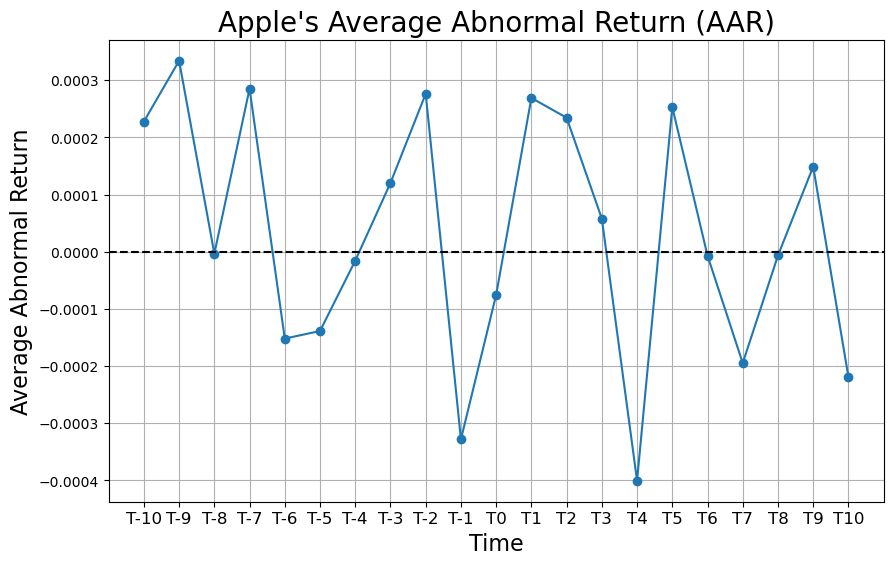

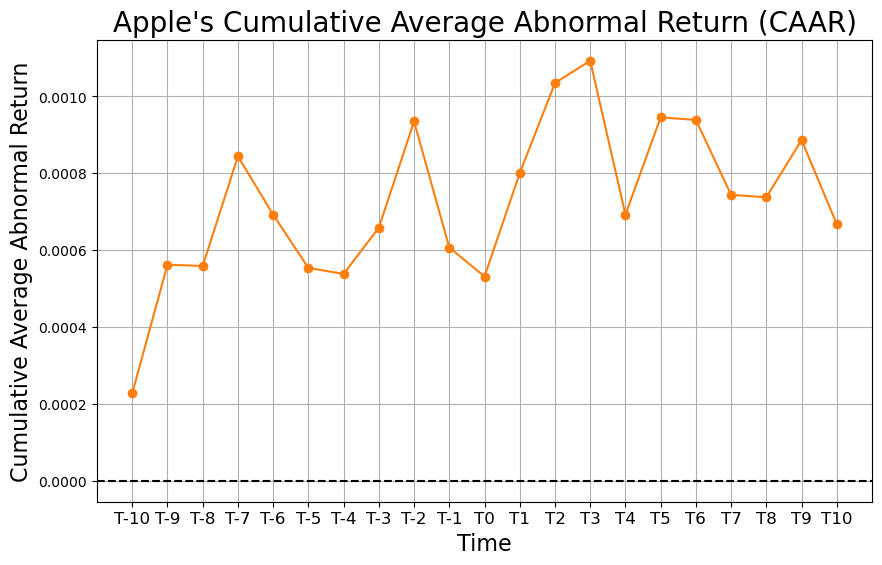

In [8]:
# Assuming AAR and CAAR are your data arrays and their length is 21 (for T-10 to T10)
time_labels = [f"T{i}" for i in range(-10, 11)]  # Generates ['T-10', 'T-9', ..., 'T0', 'T1', ..., 'T10']
time_indices = list(range(len(time_labels)))  # Generates [0, 1, 2, ..., 20]

# Plot AAR
plt.figure(figsize=(10, 6))
plt.plot(AAR, marker='o', linestyle='-', color='C0')
plt.title('Apple\'s Average Abnormal Return (AAR)', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Average Abnormal Return', fontsize=16)
plt.axhline(y=0, color='Black', linestyle='--')
plt.xticks(time_indices, time_labels, fontsize=12)
plt.grid(True)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Apple/figure_1.1.png', format='png', dpi=300)
plt.show()

# Plot CAAR
plt.figure(figsize=(10, 6))
plt.plot(CAAR, marker='o', linestyle='-', color='C1')
plt.title('Apple\'s Cumulative Average Abnormal Return (CAAR)', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Cumulative Average Abnormal Return', fontsize=16)
plt.axhline(y=0, color='Black', linestyle='--')
plt.xticks(time_indices, time_labels, fontsize=12)
plt.grid(True)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Apple/figure_1.2.png', format='png', dpi=300)
plt.show()

## 3. Abnormal Volume Analysis

### Extracting Windows for Volume

In [9]:
def get_volume_windows(datetime):
    est_start_time = datetime - pd.Timedelta(minutes=30)
    est_end_time = datetime - pd.Timedelta(minutes=10)
    est_time_range = pd.date_range(start=est_start_time, end=est_end_time, freq='min')
    
    est_volume_window = price_aapl.loc[est_time_range, 'Volume'].tolist()
    
    evt_start_time = datetime - pd.Timedelta(minutes=10)
    evt_end_time = datetime + pd.Timedelta(minutes=10)
    evt_time_range = pd.date_range(start=evt_start_time, end=evt_end_time, freq='min')
    
    evt_volume_window = price_aapl.loc[evt_time_range, 'Volume'].tolist()
    
    return est_volume_window, evt_volume_window

# Extract and combine the volume windows
volume_windows = [get_volume_windows(datetime) for datetime in tweets_market_open['datetime']]

# Separate the estimation and event windows
est_volume_windows = [window[0] for window in volume_windows]
evt_volume_windows = [window[1] for window in volume_windows]

### Calculating AV, CAV, AAV, and CAAV

In [10]:
# Initialize lists to store abnormal volumes
abnormal_volumes = []

# Calculate abnormal volumes
for i in range(len(tweets_market_open)):
    est_volumes = est_volume_windows[i]
    expected_volume = np.mean(est_volumes)
    
    evt_volumes = evt_volume_windows[i]
    abnormal_volume = [actual - expected_volume for actual in evt_volumes]
    
    abnormal_volumes.append(abnormal_volume)

# Calculate cumulative abnormal volumes (CAV) for each event
cumulative_abnormal_volumes = [sum(av) for av in abnormal_volumes]

# Calculate AAV and CAAV
AAV = np.zeros(window_length)
CAAV = np.zeros(window_length)

for i in range(window_length):
    AAV[i] = np.mean([abnormal_volumes[j][i] for j in range(n_events)])

CAAV = np.cumsum(AAV)

### Statistical Tests for AV, CAV, AAV, and CAAV

In [11]:
# Perform t-tests for AV, CAV, AAV, and CAAV
av_t_tests = [ttest_1samp(abnormal_volumes[i], 0) for i in range(n_events)]
cav_t_tests = [ttest_1samp(np.cumsum(abnormal_volumes[i]), 0) for i in range(n_events)]
aav_t_test = ttest_1samp(AAV, 0)
caav_t_test = ttest_1samp(CAAV, 0)

# Display t-test results
for i, result in enumerate(av_t_tests):
    print(f"Event {i+1} AV T-test: t-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")

for i, result in enumerate(cav_t_tests):
    print(f"Event {i+1} CAV T-test: t-statistic = {result.statistic:.4f}, p-value = {result.pvalue:.4f}")

print(f"AAV T-test: t-statistic = {aav_t_test.statistic:.4f}, p-value = {aav_t_test.pvalue:.4f}")
print(f"CAAV T-test: t-statistic = {caav_t_test.statistic:.4f}, p-value = {caav_t_test.pvalue:.4f}")

Event 1 AV T-test: t-statistic = 4.0830, p-value = 0.0006
Event 2 AV T-test: t-statistic = -0.2341, p-value = 0.8173
Event 3 AV T-test: t-statistic = -0.1664, p-value = 0.8695
Event 4 AV T-test: t-statistic = -3.4337, p-value = 0.0026
Event 5 AV T-test: t-statistic = -5.0216, p-value = 0.0001
Event 6 AV T-test: t-statistic = -3.2381, p-value = 0.0041
Event 7 AV T-test: t-statistic = 2.4123, p-value = 0.0256
Event 8 AV T-test: t-statistic = 4.6999, p-value = 0.0001
Event 9 AV T-test: t-statistic = -6.7198, p-value = 0.0000
Event 1 CAV T-test: t-statistic = 8.2037, p-value = 0.0000
Event 2 CAV T-test: t-statistic = 6.6730, p-value = 0.0000
Event 3 CAV T-test: t-statistic = -2.5909, p-value = 0.0175
Event 4 CAV T-test: t-statistic = -6.9728, p-value = 0.0000
Event 5 CAV T-test: t-statistic = -7.4290, p-value = 0.0000
Event 6 CAV T-test: t-statistic = -5.0825, p-value = 0.0001
Event 7 CAV T-test: t-statistic = 8.3552, p-value = 0.0000
Event 8 CAV T-test: t-statistic = 5.1739, p-value = 0.0

### Visualization

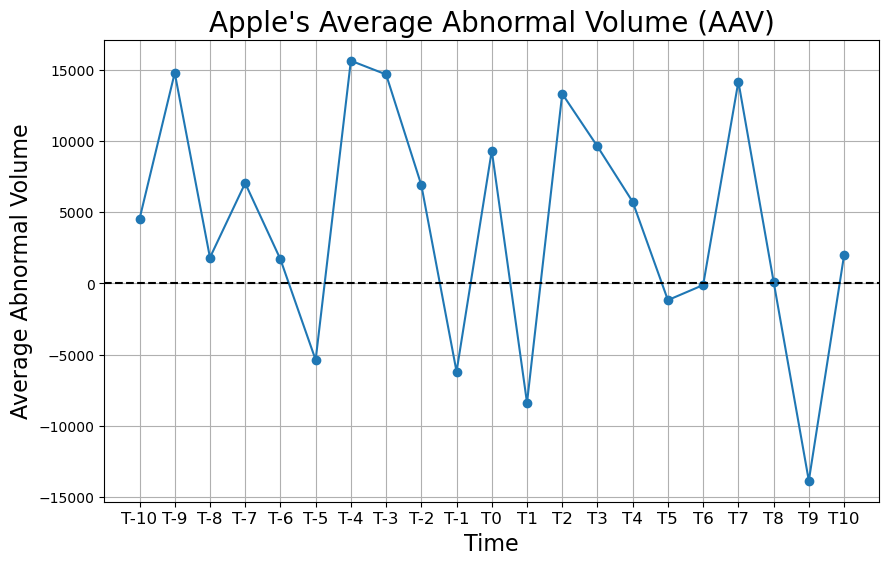

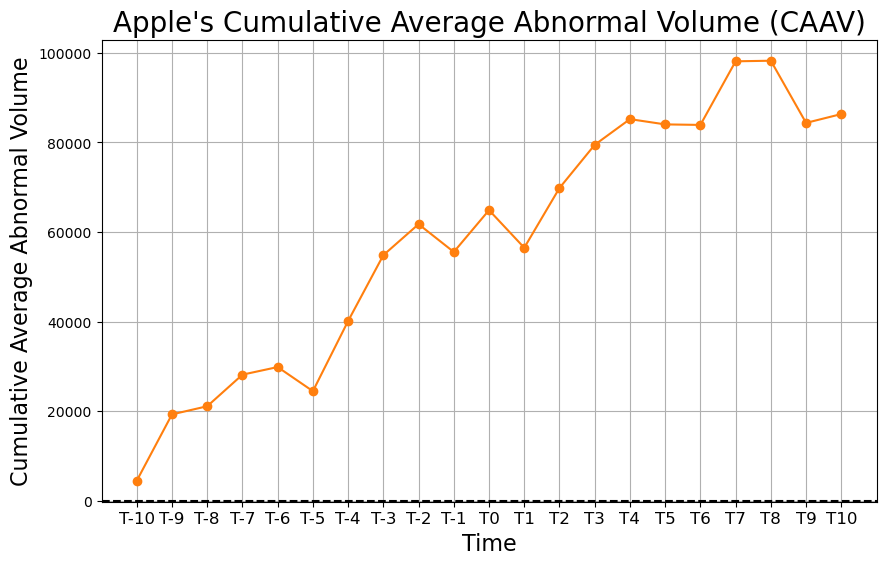

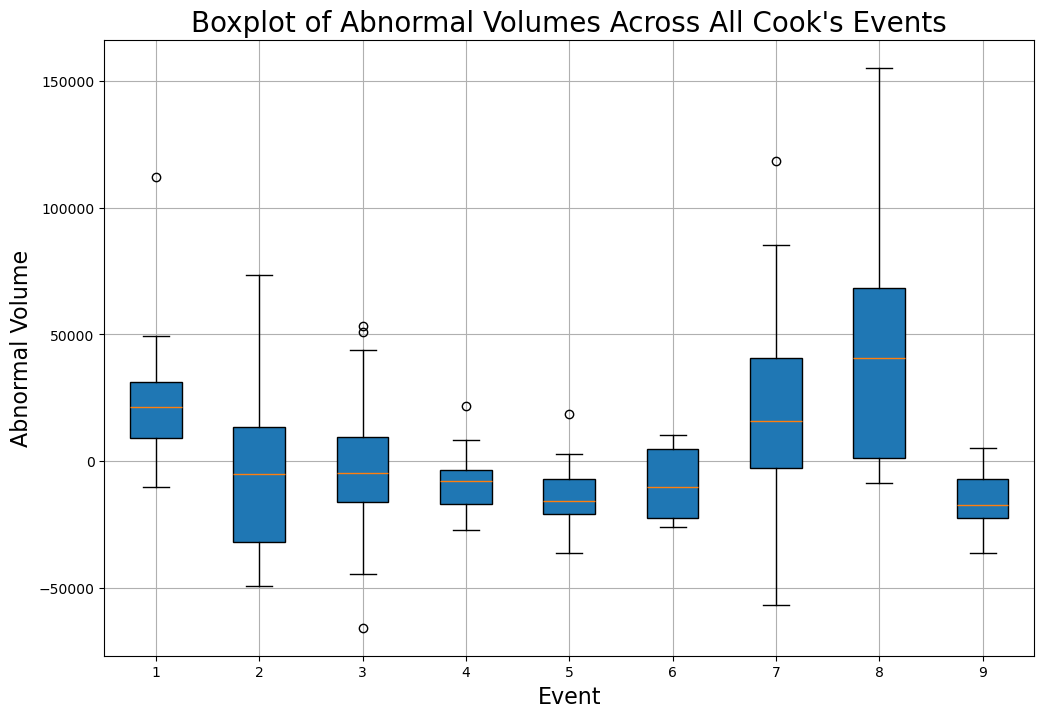

In [12]:
# Plot Average Abnormal Volume (AAV)
plt.figure(figsize=(10, 6))
plt.plot(AAV, marker='o', linestyle='-', color='C0')
plt.title('Apple\'s Average Abnormal Volume (AAV)', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Average Abnormal Volume', fontsize=16)
plt.axhline(y=0, color='Black', linestyle='--')
plt.xticks(time_indices, time_labels, fontsize=12)
plt.grid(True)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Apple/figure_1.3.png', format='png', dpi=300)
plt.show()

# Plot Cumulative Average Abnormal Volume (CAAV)
plt.figure(figsize=(10, 6))
plt.plot(CAAV, marker='o', linestyle='-', color='C1')
plt.title('Apple\'s Cumulative Average Abnormal Volume (CAAV)', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Cumulative Average Abnormal Volume', fontsize=16)
plt.axhline(y=0, color='Black', linestyle='--')
plt.xticks(time_indices, time_labels, fontsize=12)
plt.grid(True)
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Apple/figure_1.4.png', format='png', dpi=300)
plt.show()

# Create a boxplot for abnormal volumes across all events
plt.figure(figsize=(12, 8))
plt.boxplot(abnormal_volumes, patch_artist=True)

# Adding title and labels
plt.title('Boxplot of Abnormal Volumes Across All Cook\'s Events', fontsize=20)
plt.xlabel('Event', fontsize=16)
plt.ylabel('Abnormal Volume', fontsize=16)

# Adding grid for better readability
plt.grid(True)

# Show the plot
plt.savefig('/Users/sunlexlin/Desktop/UCL/Term 3/FRP/My work/Apple/figure_1.5.png', format='png', dpi=300)
plt.show()